Adapted in notebook time_series_gp_s+l_pulse_kernel_step_by_step:
- Use data file sim_pulse.lc
- Add random noise to the data
- Use a kernel with one SHO term
- Find the best prior frequency

In [1]:
import os
import sys
import math
%load_ext autoreload
%autoreload 2

import numpy as np
np.random.seed(0)

# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
from spleaf import cov, term
from scipy.optimize import fmin_l_bfgs_b

import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

# Start the notebook from the root of the project
if 'notebooks' in os.getcwd():
    os.chdir(os.path.dirname(os.getcwd()))
    if os.getcwd().endswith('notebooks'):
        os.chdir(os.path.dirname(os.getcwd()))

 # Local imports (i.e., my code) from the src folder
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

import experiment_util
from plot_helpers import *
plotter = PlotUtilSPLeaf()

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

Read the first time series

In [3]:
df = pd.read_csv("data/sim_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')

In [4]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
## Zoomed in on the first N observations

In [5]:
# This library becomes unstable at N=15125
# N=15125
N=X.shape[0]
N_samples=11300

In [6]:
X_part=X[:N_samples]
Y_part=Y[:N_samples]
N_part, YpN_part = experiment_util.generate_random_noise(Y_part)

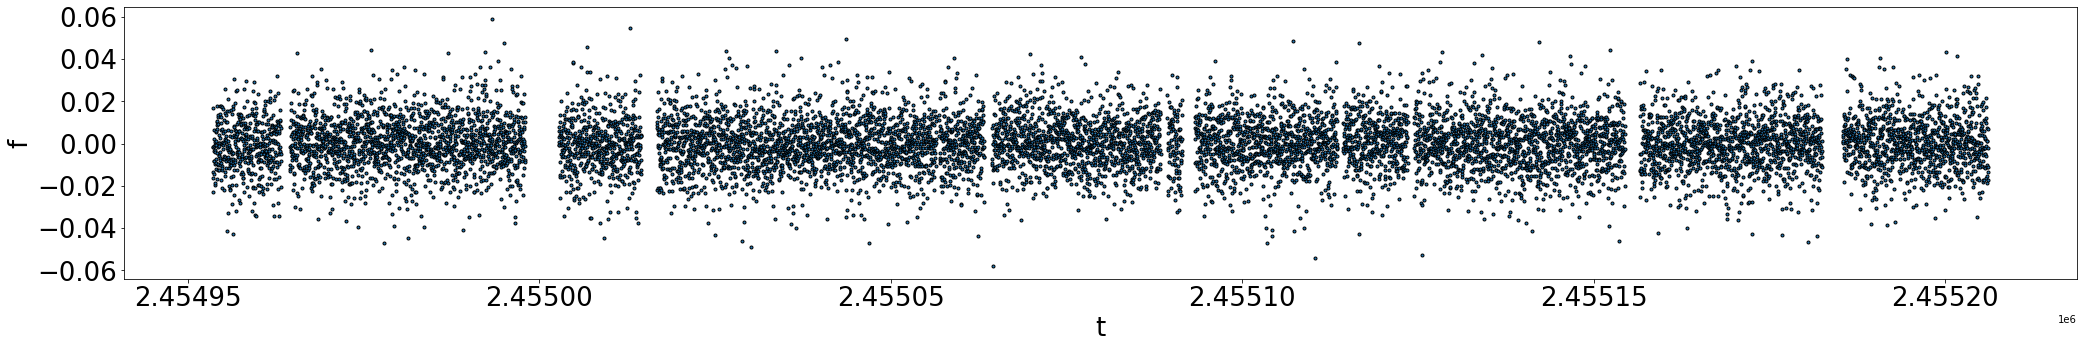

In [7]:
plotter.plot_data(X_part, N_part)

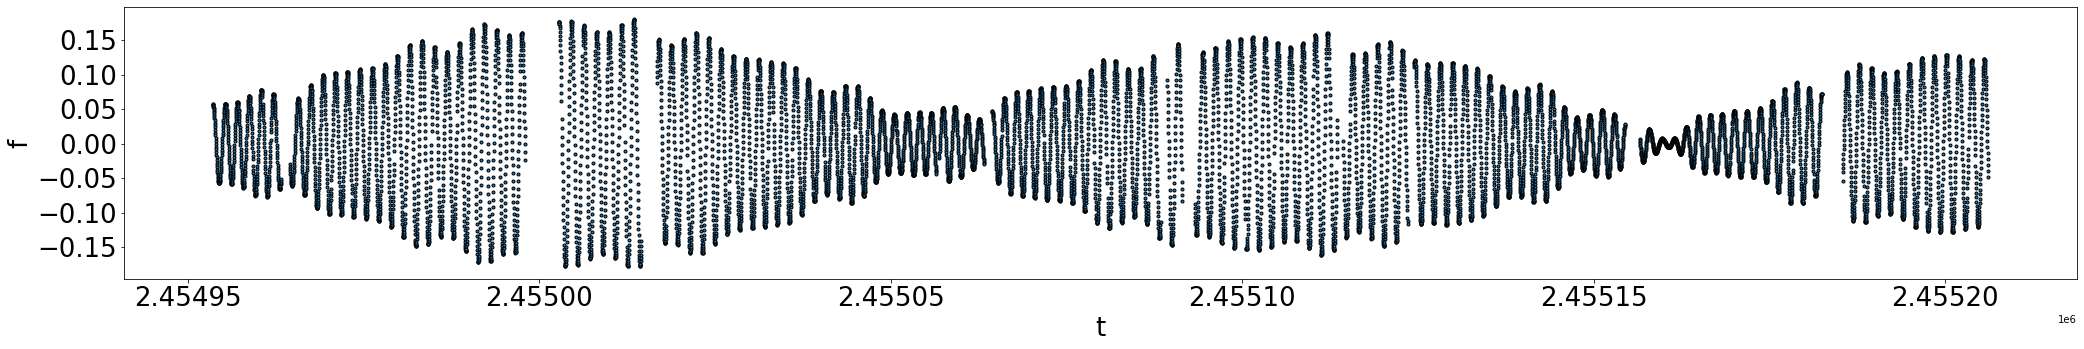

In [8]:
plotter.plot_data(X_part, Y_part)

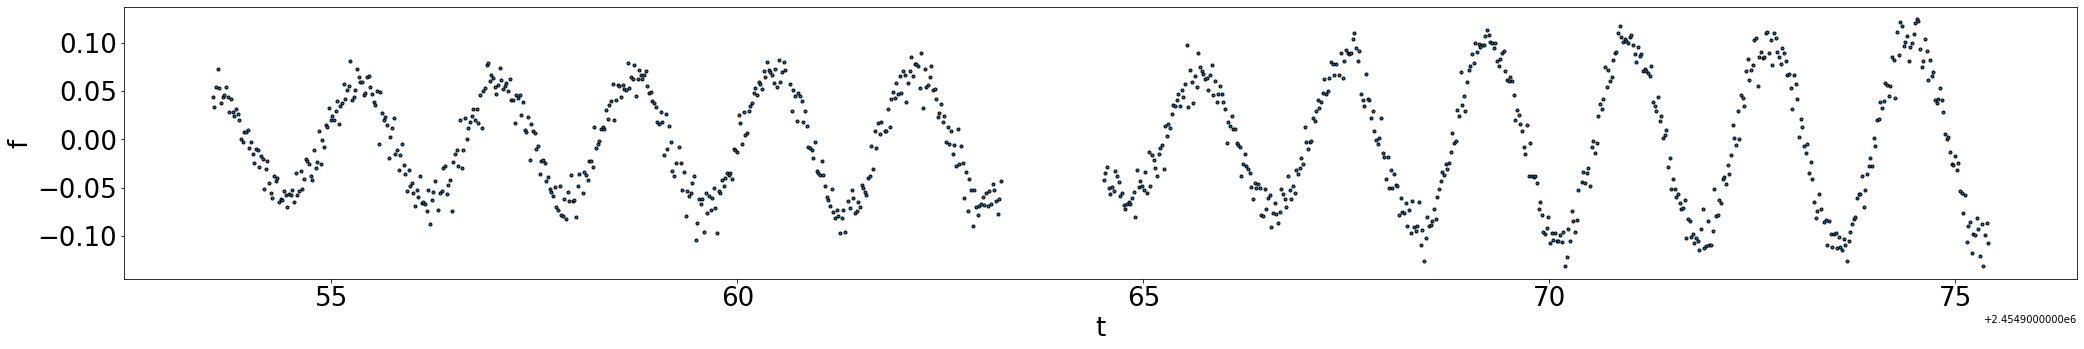

In [9]:
plotter.plot_data(X_part[:1000], YpN_part[:1000])

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [10]:
# Run one by one with frequencies [0.1, 0.4, 0.5673, 0.6, 0.7, 10.0]
freq = 0.1

In [11]:
# Predict evenly spaced points on our time-axis
X_part_smooth = np.linspace(X_part.min(), X_part.max(), N_samples)

In [12]:
# Define the function to minimize
def negloglike(x, y, cov_matrix, params_to_fit):
   cov_matrix.set_param(x, params_to_fit)
   nll = -cov_matrix.loglike(y)
   # gradient
   nll_grad = -cov_matrix.loglike_grad()[1]
   return(nll, nll_grad)

In [13]:
# Initialize the S+LEAF model with one term
cov_matrix = cov.Cov(X_part,
   sho = term.SHOKernel(sig=-0.056267, P0=1/freq, Q=8000.36505))

In [14]:
# List of parameters to fit: fit sigma only, we pre-set the undamped period and Q
params_to_fit = cov_matrix.param[:1]

# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
xbest,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix.get_param(), args=(Y_part, cov_matrix, params_to_fit))

In [15]:
# We first use S+LEAF to predict the missing data on the training data scope

In [16]:
cov_matrix.set_param(xbest, params_to_fit)
Y_part_pred, _ = cov_matrix.conditional(YpN_part, X_part, calc_cov='diag')
experiment_util.calculate_error(YpN_part, Y_part_pred)

TimeSeriesSimilarity(correlation=0.9999999998147472, rmse=1.544596429575729e-06)

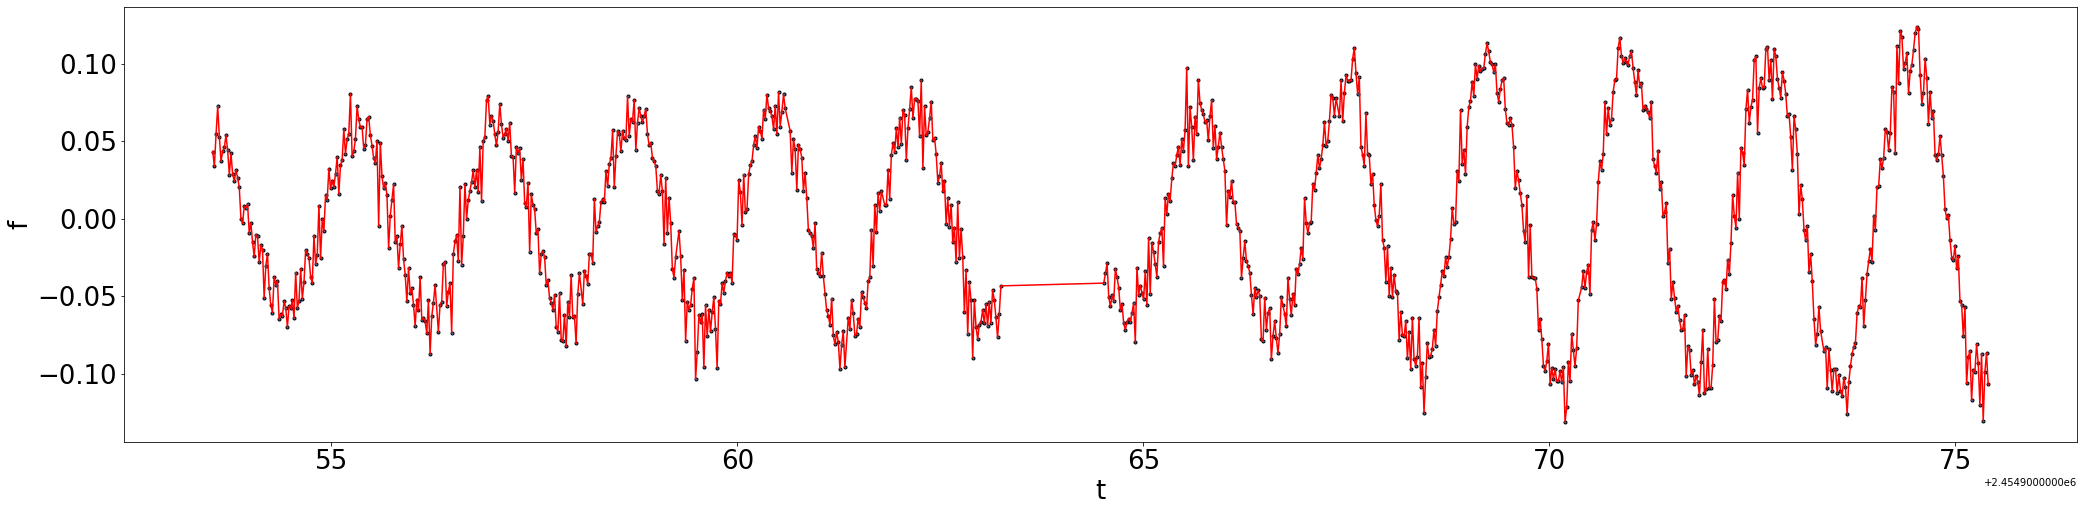

In [17]:
plotter.plot_series(X_part[:1000], YpN_part[:1000], X_part[:1000], Y_part_pred[:1000])

In [18]:
# We now use S+LEAF to predict the missing data on the training data scope and fill in the gaps
cov_matrix.set_param(xbest, params_to_fit)
Y_part_smooth, var_part_smooth = cov_matrix.conditional(YpN_part, X_part_smooth, calc_cov='diag')
experiment_util.calculate_error(YpN_part, Y_part_smooth)

TimeSeriesSimilarity(correlation=0.03538713346642847, rmse=0.12881061658298573)

In [19]:
cov_matrix.get_param('sho.sig'), 1/cov_matrix.get_param('sho.P0'), cov_matrix.get_param('sho.Q')

(-16.77528192681618, 0.1, 8000.36505)

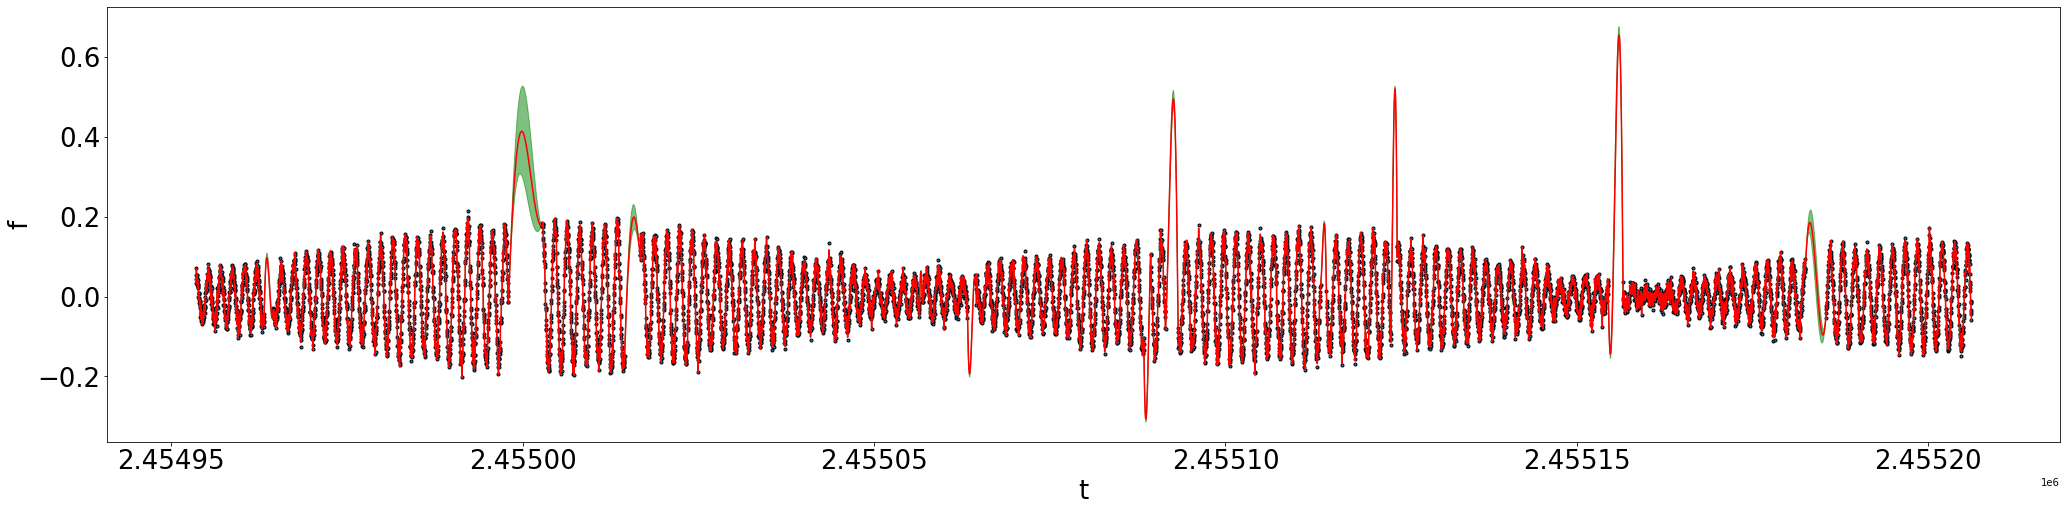

In [20]:
plotter.plot_series(X_part, YpN_part, X_part_smooth, Y_part_smooth, var_part_smooth)